In [1]:
from IPython.display import SVG
import numpy as np
import pandas as pd
%load_ext rpy2.ipython

In [2]:
def recombination(i):
    """
    This function returns all possible states after a 
    single recombination event given an initial state
    """
    # Create empty list
    new_lst = []
    # For each block index in the list
    for block in range(len(i)):
        # If the site is linked
        if 0 not in i[block]:
            # Remove block
            lst = i[:block]+i[block+1:]
            # Split block
            lst = lst + [(i[block][0], 0), (0, i[block][1])]
            # Append to list
            new_lst.append(sorted(lst))
    return new_lst

In [3]:
def coalescent(i):
    """
    This function returns all possible states after a 
    single coalescence event given an initial state. 
    The returned list is somewhat ordered, so that the 
    first states correspond to reversible coalescence 
    events, and the last to non-reversible ones.
    """
    # Get unique values per site
    n_0 = set([0]+list(sum(i, ())))
    reversible = []
    nonreversible = []
    # For each combination of blocks
    for b1 in range(len(i)):
        for b2 in range(b1+1, len(i)):
            # Create new block by merging
            add_lst = [(i[b1][0]+i[b2][0], i[b1][1]+i[b2][1])]
            # For each index in i
            for b3 in range(len(i)):
                # If the index is not in among the merged blocks
                if b3 not in [b1, b2]:
                    # Append to list
                    add_lst.append(i[b3])
            # If the unique values are different from the 
            # original block
            if set([0]+list(sum(add_lst, ()))) == n_0:
                # Append to reversible coalescence list
                reversible.append(sorted(add_lst))
            else:
                # Append to non-reversible coalescence list
                nonreversible.append(sorted(add_lst))
    l = reversible+nonreversible
    return l

In [4]:

def idx(i):
    j = list(sum(i, ()))
    return -(len(j)-j.count(0))

def get_states(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively.
    """
    # Sort block per states just in case
    all_states = [sorted(i) for i in lst]
    # Define pool of states to be transformed
    state_pool = all_states
    # While the pool is non-empty
    while len(state_pool) > 0:
        # Define result list per iteration
        iter_states = []
        # For each of the states in the pool
        for i in state_pool:
            # Save coalescent transformation
            iter_states = iter_states+coalescent(i)
            # Save recombination transformation
            iter_states = iter_states+recombination(i)
        # Keep unique values in the original order
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        # Define pool for next round
        state_pool = [i for i in iter_states if i not in all_states]
        # Add pool to overall list
        all_states += state_pool
        
    all_states = sorted(all_states, key = idx)
    return all_states

import multiprocessing as mp
def get_states_parallel(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively and in
    parallel.
    """
    all_states = [sorted(i) for i in lst]
    state_pool = all_states
    while len(state_pool) > 0:
        print(len(all_states), end = '\r')
        iter_states = []
        pool = mp.Pool(mp.cpu_count())
        iter_states = iter_states+[item for sublist in pool.map(coalescent, state_pool) for item in sublist]
        iter_states = iter_states+[item for sublist in pool.map(recombination, state_pool) for item in sublist]
        pool.close()
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        state_pool = [i for i in iter_states if i not in all_states]
        all_states += state_pool
    all_states = sorted(all_states, key = idx)
    return all_states


In [5]:
def colored(r, g, b, text):
    """
    Given some color coordinates in RGB and 
    some text, this function returns the text in
    the right format for printing in color. 
    """
    return "\033[38;2;{};{};{}m{}\033[38;2;000;000;000m".format(r, g, b, text)

dct = {
    1:('204', '000', '000'),
    2:('000', '000', '204'),
    4:('204', '204', '000'),
    3:('204', '000', '204'),
    5:('204', '102', '000'),
    6:('000', '204', '000'),
    7:('000', '000', '000'),
}

for i in dct:
    entry = dct[i]
    print('-'+colored(entry[0], entry[1], entry[2], i))


-1
-2
-4
-3
-5
-6
-7


In [6]:
def print_states(i, fill):
    """
    This function transforms a numerical representation
    of an entry of the state space into a string with 
    coloring that can be used to print the entry in a 
    ball-and-stick representation. This function only 
    works for a population size of up to 3 individuals.
    The argument fill is used to specify the height of 
    the print. If fill exceeds the natural height of the
    printed state, then trailing whitespaces will be 
    printed.
    """
    string = ' ______ \n'
    for j in i:
        string += '| '
        if j[0] == 0:
            string += '  '
        else:
            entry = dct[j[0]]
            if j[0] in [1, 2, 4]:
                symbol = '●'
            else:
                symbol = 'X'
            string += (colored(entry[0], entry[1], entry[2], symbol)+'-')
        if j[1] == 0:
            string += '  '
        else:
            if j[1] in [1, 2, 4]:
                symbol = '●'
            else:
                symbol = 'X'
            entry = dct[j[1]]
            string += ('-'+colored(entry[0], entry[1], entry[2], symbol))
        string += ' |\n'
    string += ' ‾‾‾‾‾‾ '
    string += '\n        '*(fill-len(string.split('\n')))
    return string

print(print_states([(0, 1), (0, 2), (0, 4), (1, 0), (6, 0)], 6))

 ______ 
|   -● |
|   -● |
|   -● |
| ●-   |
| X-   |
 ‾‾‾‾‾‾ 


In [7]:
def print_all_states(iter_lst, n_col):
    """
    This function re-formats the output of print_states
    for plotting several states in the same row/column. The 
    arguments are a list of states and the number of
    columns for printing. The returned object is a list 
    containing the string for each of the rows.  
    """
    # Define empty string holder list
    new_string = []
    # For each row
    for row in range(0, len(iter_lst), n_col):
        
        # Define index of the final state of that row
        end = row+n_col
        if end > len(iter_lst):
            end = len(iter_lst)
        
        # Save the height of the current row
        max_len = max([len(i) for i in iter_lst[row:end]])+2
        
        # Print states in right format with trailing whitespaces
        x = []
        for i in iter_lst[row:end]:
            x.append(print_states(i, max_len))
        
        # Define new empty string
        string = ''
        # For each row within each printed state
        for max_depth in range(max_len):
            # For each printed state
            for i in x:
                # Add row
                string += i.split('\n')[max_depth]
            string += '\n'
        # Append new string to final result
        new_string.append(string[:-2])
    
    return new_string


## Representing the state space

Through this document, each of the elements of the state space will be represented as a list of tuples of length 2, where each tuple is a genome consisting of two linked sites or a single unlinked site. For example, `(1, 1)` represents two linked sites, and `(0, 1)` represents an unlinked right site. We can use the function `print_all_states` to get a graphical representation of these:

In [8]:
state_example = [[(1, 1)], [(0, 1), (1, 0)]]
for i in print_all_states(state_example, 2):
    print(i)

 ______  ______ 
| ●--● ||   -● |
 ‾‾‾‾‾‾ | ●-   |
         ‾‾‾‾‾‾


For a population of 1 (1 allele per site) it is straightforward to calculate all 2 possible states. For more alleles, we need a way to represent the non-reversible coalescent events, this is, those coalescent events that happen between two sites of in the same side (either left or right) and, thus, cannot be undone by recombination. If we use `1` to represent one population and `2` to represent a second one, then a non-reversible coalescent event between these two can be represented with a `3`. If we have more populations, then we need numbers that, when added, do not represent nothing else than the non-reversible coalescent of two specific alleles. For three populations, we can assign `4` to the third population. If we calculate the sum of all possible combinations, we will see that none of them is repeated:

In [9]:
from itertools import combinations

lst = [1, 2, 4]
comb = []
for i in range(1, len(lst)+1):
    [comb.append(sum(j)) for j in list(combinations(lst, i))]
print(comb)
sorted(list(set(comb))) == sorted(comb)

[1, 2, 4, 3, 5, 6, 7]


True

This is a property of superincreasing integer sequences. Among all of the possible supeincreasing sequences, we can pick the minimally superincreasing one, which is simply $1, 2, 4, 8, 16, ..., 2^n$:

In [10]:
from itertools import combinations
lst = [1, 2, 4, 8]
comb = []
for i in range(2, len(lst)+1):
    [comb.append(sum(j)) for j in list(combinations(lst, i))]
print(comb)
sorted(list(set(comb))) == sorted(comb)

[3, 5, 9, 6, 10, 12, 7, 11, 13, 14, 15]


True

In [11]:
lst = [1, 2, 4, 8, 16]
comb = []
for i in range(2, len(lst)+1):
    [comb.append(sum(j)) for j in list(combinations(lst, i))]
print(comb)
sorted(list(set(comb))) == sorted(comb)

[3, 5, 9, 17, 6, 10, 18, 12, 20, 24, 7, 11, 19, 13, 21, 25, 14, 22, 26, 28, 15, 23, 27, 29, 30, 31]


True

We now have a framework to define all states for a certain number of populations (or individuals). Given that there are only two possible "rules" for transitioning from one state to another (namely, coalescence or recombination), we can define functions that transform a state according to these rules:

In [12]:
# Recombination

i = [(1, 1), (2, 2), (4, 4)]
print(print_states(i, 0))
[print(i) for i in print_all_states(recombination(i), 3)]

 ______ 
| ●--● |
| ●--● |
| ●--● |
 ‾‾‾‾‾‾ 
 ______  ______  ______ 
|   -● ||   -● ||   -● |
| ●-   || ●--● || ●--● |
| ●--● || ●-   || ●--● |
| ●--● || ●--● || ●-   |
 ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾


[None]

In [13]:
# Coalescent

i = [(1, 1), (0, 2), (4, 4), (2, 0)]
print(print_states(i, 0))
[print(i) for i in print_all_states(coalescent(i), 6)]

 ______ 
| ●--● |
|   -● |
| ●--● |
| ●-   |
 ‾‾‾‾‾‾ 
 ______  ______  ______  ______  ______  ______ 
| ●--● || ●--X ||   -● ||   -● || ●--● ||   -● |
| ●--● || ●-   || ●-   || X--● || ●-   || ●--● |
| ●--● || ●--● || X--X || ●--● || ●--X || X--● |
 ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾


[None]

Note that the non-reversible coalescents are representes as crosses instead of balls. The color of the cross corresponds to the mix of colors representing the two individuals where it comes from. This way, pink represents red+blue, orange represents red+yellow and green represents blue+yellow. Additionally, black crosses represents the absorbing state, this is, red+blue+yellow.

## One individual

Using the above rules, we can get the all possible states for one individual. The function `get_states` iteratively finds all possible states given a starting state:

In [14]:
state_1 = [[(1, 1)]]
iter_lst_1 = get_states(state_1)
print(iter_lst_1)

[[(1, 1)], [(0, 1), (1, 0)]]


In [15]:
for i in print_all_states(iter_lst_1, 2):
    print(i)

 ______  ______ 
| ●--● ||   -● |
 ‾‾‾‾‾‾ | ●-   |
         ‾‾‾‾‾‾


The resulting 2x2 transition matrix can easily be created in this case:

In [16]:
trans_mat_1 = np.full((len(iter_lst_1), len(iter_lst_1)), '0')

trans_mat_1[0, 1] = 'C'
trans_mat_1[1, 0] = 'R'

df = pd.DataFrame(trans_mat_1)
print(df)

   0  1
0  0  C
1  R  0


And we can also retrieve non-zero matrix values in tidy format by melting the dataframe:

In [17]:
new_df = (df.rename_axis(index = 'from')
            .reset_index()
            .melt('from', var_name='to')
            .reindex(columns = ['value','from','to']))
tab_mat_1 = new_df[new_df['value'] != '0']
tab_mat_1

,value,from,to
1,R,1,0
2,C,0,1


## Two individuals

Following Mailund et al. (2011), there are 15 different states for the 2-individual case. We can compute all these using `get_states`:

In [18]:
state_2 = [[(0, 1), (0, 2), (1, 0), (2, 0)]]
iter_lst_2 = get_states(state_2)
iter_lst_2

[[(0, 1), (0, 2), (1, 0), (2, 0)],
 [(0, 2), (1, 1), (2, 0)],
 [(0, 2), (1, 0), (2, 1)],
 [(0, 1), (1, 2), (2, 0)],
 [(0, 1), (1, 0), (2, 2)],
 [(1, 1), (2, 2)],
 [(1, 2), (2, 1)],
 [(0, 3), (1, 0), (2, 0)],
 [(0, 1), (0, 2), (3, 0)],
 [(1, 3), (2, 0)],
 [(0, 2), (3, 1)],
 [(1, 0), (2, 3)],
 [(0, 1), (3, 2)],
 [(0, 3), (3, 0)],
 [(3, 3)]]

In [19]:
for i in print_all_states(iter_lst_2, 5):
    print(i)

 ______  ______  ______  ______  ______ 
|   -● ||   -● ||   -● ||   -● ||   -● |
|   -● || ●--● || ●-   || ●--● || ●-   |
| ●-   || ●-   || ●--● || ●-   || ●--● |
| ●-   | ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾ 
 ‾‾‾‾‾‾                                
 ______  ______  ______  ______  ______ 
| ●--● || ●--● ||   -X ||   -● || ●--X |
| ●--● || ●--● || ●-   ||   -● || ●-   |
 ‾‾‾‾‾‾  ‾‾‾‾‾‾ | ●-   || X-   | ‾‾‾‾‾‾ 
                 ‾‾‾‾‾‾  ‾‾‾‾‾‾        
 ______  ______  ______  ______  ______ 
|   -● || ●-   ||   -● ||   -X || X--X |
| X--● || ●--X || X--● || X-   | ‾‾‾‾‾‾ 
 ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾        


We can now calculate the transition matrix by recording where transitions can happen. `R` is the recombination rate, while `C` is the coalescent rate:

In [20]:
trans_mat_2 = np.full((len(iter_lst_2), len(iter_lst_2)), '0')

for i in range(len(iter_lst_2)):
    new_lst = recombination(iter_lst_2[i])
    idx_lst = [iter_lst_2.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_2[i,j]='R'
    new_lst = coalescent(iter_lst_2[i])
    idx_lst = [iter_lst_2.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_2[i,j]='C'
        
pd.DataFrame(trans_mat_2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,C,C,C,C,0,0,C,C,0,0,0,0,0,0
1,R,0,0,0,0,C,0,0,0,C,C,0,0,0,0
2,R,0,0,0,0,0,C,0,0,0,C,C,0,0,0
3,R,0,0,0,0,0,C,0,0,C,0,0,C,0,0
4,R,0,0,0,0,C,0,0,0,0,0,C,C,0,0
5,0,R,0,0,R,0,0,0,0,0,0,0,0,0,C
6,0,0,R,R,0,0,0,0,0,0,0,0,0,0,C
7,0,0,0,0,0,0,0,0,0,C,0,C,0,C,0
8,0,0,0,0,0,0,0,0,0,0,C,0,C,C,0
9,0,0,0,0,0,0,0,R,0,0,0,0,0,0,C


We can get the same matrix in tidy format:

In [21]:
df = pd.DataFrame(trans_mat_2)
new_df = (df.rename_axis(index = 'from')
            .reset_index()
            .melt('from', var_name='to')
            .reindex(columns = ['value','from','to']))
tab_mat_2 = new_df[new_df['value'] != '0']
tab_mat_2.head()

,value,from,to
1,R,1,0
2,R,2,0
3,R,3,0
4,R,4,0
15,C,0,1


Because the states returned by `get_states` are somewhat ordered, we can also get cutpoints for plotting the data that show the structure of the transition rate matrix. These cutpoints represent either the boundaries between the number of remaining alleles (transitions due to non-reversible coalescents) or the boundaries between the number of genomes (transitions due to reversible coalescents):

In [22]:
cutpoints_2_1 = []
for i in range(1, len(iter_lst_2)):
    if len(iter_lst_2[i]) < len(iter_lst_2[i-1]):
        cutpoints_2_1.append(i)
cutpoints_2_2 = []
for i in range(1, len(iter_lst_2)):
    if idx(iter_lst_2[i]) > idx(iter_lst_2[i-1]):
        cutpoints_2_2.append(i)

The resulting matrix shows the transitions between all 15 states, where coalescents are in red and recombinations in blue. Gray lines represent reversible coalescent events, while black lines represent non-reversible coalescents. 

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



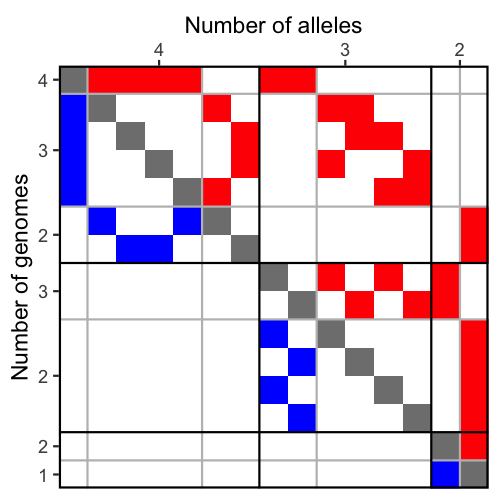

In [23]:
%%R -i tab_mat_2 -i cutpoints_2_1  -i cutpoints_2_2  -w 500 -h 500 -r 150

library(tidyverse)

cutpoints_2_1 <- tibble(x = unlist(cutpoints_2_1))
cutpoints_2_2 <- tibble(x = unlist(cutpoints_2_2))
a <- sort(c(0, max(tab_mat_2$to)+1, cutpoints_2_1$x, cutpoints_2_2$x))
a <- a[-length(a)] + diff(a)/2 - 0.5
b <- sort(c(0, max(tab_mat_2$to)+1, cutpoints_2_2$x))
b <- b[-length(b)] + diff(b)/2 - 0.5



as_tibble(tab_mat_2) %>% 
    ggplot() +
    geom_tile(aes(to, from, fill = value)) +
    geom_tile(aes(x, y, fill = fill), 
              data = tibble(x = 0:max(tab_mat_2$to), y = 0:max(tab_mat_2$to), fill = NA)) +
    geom_hline(aes(yintercept = x-0.5), data = cutpoints_2_1, color = 'grey') +
    geom_vline(aes(xintercept = x-0.5), data = cutpoints_2_1, color = 'grey') +
    geom_hline(aes(yintercept = x-0.5), data = cutpoints_2_2) +
    geom_vline(aes(xintercept = x-0.5), data = cutpoints_2_2) +
    scale_y_reverse(
        name = 'Number of genomes',
        expand = c(0, 0), 
        breaks = a,
        labels = c(4, 3, 2, 3, 2, 2, 1)
    ) +
    scale_x_continuous(
        name = 'Number of alleles',
        expand = c(0, 0),
        breaks = b,
        labels = 4:2,
        position = "top"
    ) +
    theme(legend.position = 'none',
          panel.border = element_rect(colour = "black", fill = NA, size = 1),
          axis.line=element_blank(),
          panel.background=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
    scale_fill_manual(values = c('red', 'blue')) 

In [24]:
iter_lst_2

[[(0, 1), (0, 2), (1, 0), (2, 0)],
 [(0, 2), (1, 1), (2, 0)],
 [(0, 2), (1, 0), (2, 1)],
 [(0, 1), (1, 2), (2, 0)],
 [(0, 1), (1, 0), (2, 2)],
 [(1, 1), (2, 2)],
 [(1, 2), (2, 1)],
 [(0, 3), (1, 0), (2, 0)],
 [(0, 1), (0, 2), (3, 0)],
 [(1, 3), (2, 0)],
 [(0, 2), (3, 1)],
 [(1, 0), (2, 3)],
 [(0, 1), (3, 2)],
 [(0, 3), (3, 0)],
 [(3, 3)]]

In [30]:
dat = pd.DataFrame(columns = ['id', 'seg_y', 'seg_xmin', 'seg_xmax', 'dot_color_left', 'dot_color_right'])

In [29]:
for i in iter_lst_2[0]:
    print(i)

(0, 1)
(0, 2)
(1, 0)
(2, 0)


In [87]:
def iter_lst_to_ggplot(iter_lst_2):
    dat = pd.DataFrame(columns = ['id', 'seg_y', 'seg_xmin', 'seg_xmax', 'dot_color_left', 'dot_color_right'])
    for i in range(len(iter_lst_2)):
        for j in range(len(iter_lst_2[i])):
            if iter_lst_2[i][j][0] == 0:
                xmin = 0
                xmax = 1
                left = '-'
                right = str(iter_lst_2[i][j][1])
            elif iter_lst_2[i][j][1] == 0:
                xmin = -1
                xmax = 0
                left = str(iter_lst_2[i][j][0])
                right = '-'
            else:
                xmin = -1
                xmax = 1
                left = str(iter_lst_2[i][j][0])
                right = str(iter_lst_2[i][j][1])
            dat.loc[len(dat)] = [i, j, xmin, xmax, left, right]
    return dat

dat_2 = iter_lst_to_ggplot(iter_lst_2)

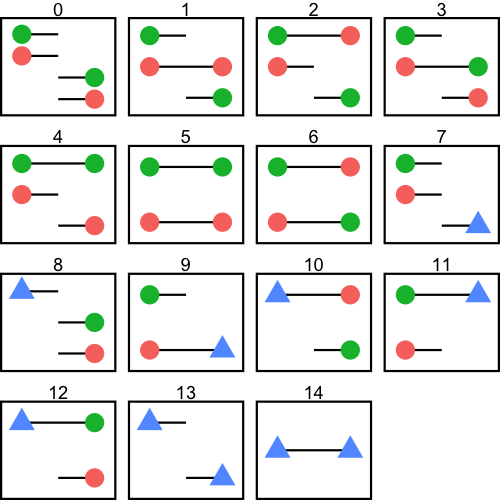

In [98]:
%%R -i dat_2 -w 500 -h 500 -r 150

as_tibble(dat_2) %>%
    mutate(
        dot_color_left = ifelse(dot_color_left == '-', NA, dot_color_left),
        dot_color_right = ifelse(dot_color_right == '-', NA, dot_color_right)
    ) %>%
    ggplot() +
    geom_segment(aes(x = seg_xmin, xend = seg_xmax,
                     y = seg_y, yend = seg_y)) +
    geom_point(aes(x = seg_xmin, y = seg_y, 
                   color = dot_color_left, fill = dot_color_left,
                  shape = dot_color_left %in% c('1', '2', '4')),
              size = 4) +
    geom_point(aes(x = seg_xmax, y = seg_y, color = dot_color_right,
              shape = dot_color_right %in% c('1', '2', '4')),
              size = 4) +
    theme_void() +
    facet_wrap(~id, scales = 'free') +
    scale_color_discrete(na.value = 'transparent') +
    scale_fill_discrete(na.value = 'transparent') +
    scale_shape_manual(values=c(17, 16)) +
    scale_x_continuous(expand = c(0.2, 0.2)) +
    scale_y_continuous(expand = c(0.2, 0.2)) +
    theme(legend.position = 'none',
          panel.border = element_rect(colour = "black", fill = NA, size = 1),
          axis.line=element_blank(),
          panel.background=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) 

## Three populations

In [89]:
state_3 = [[(0, 1), (0, 2), (0, 4), (1, 0), (2, 0), (4, 0)]]

iter_lst_3 = get_states(state_3)
len(iter_lst_3)

203

In [22]:
#state_3 = [[(0, 1), (0, 2), (0, 4), (1, 0), (2, 0), (4, 0)]]
#iter_lst_3 = get_states_parallel(state_n)
#len(iter_lst_3)

In [90]:
cutpoints_3_1 = []
for i in range(1, len(iter_lst_3)):
    if len(iter_lst_3[i]) < len(iter_lst_3[i-1]):
        cutpoints_3_1.append(i)
cutpoints_3_1

[1, 10, 28, 40, 76, 123, 165, 189, 202]

In [91]:
cutpoints_3_2 = []
for i in range(1, len(iter_lst_3)):
    if idx(iter_lst_3[i]) > idx(iter_lst_3[i-1]):
        cutpoints_3_2.append(i)
cutpoints_3_2

[34, 112, 183, 201]

In [92]:
import numpy as np
trans_mat_3 = np.full((len(iter_lst_3), len(iter_lst_3)), '0')

for i in range(len(iter_lst_3)):
    new_lst = recombination(iter_lst_3[i])
    idx_lst = [iter_lst_3.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_3[i,j]='R'
    new_lst = coalescent(iter_lst_3[i])
    idx_lst = [iter_lst_3.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_3[i,j]='C'

In [93]:
df = pd.DataFrame(trans_mat_3)
new_df = (df.rename_axis(index = 'from')
            .reset_index()
            .melt('from', var_name='to')
            .reindex(columns = ['value','from','to']))
tab_mat_3 = new_df[new_df['value'] != '0']
tab_mat_3

,value,from,to
1,R,1,0
2,R,2,0
3,R,3,0
4,R,4,0
5,R,5,0
...,...,...,...
41203,C,197,202
41204,C,198,202
41205,C,199,202
41206,C,200,202


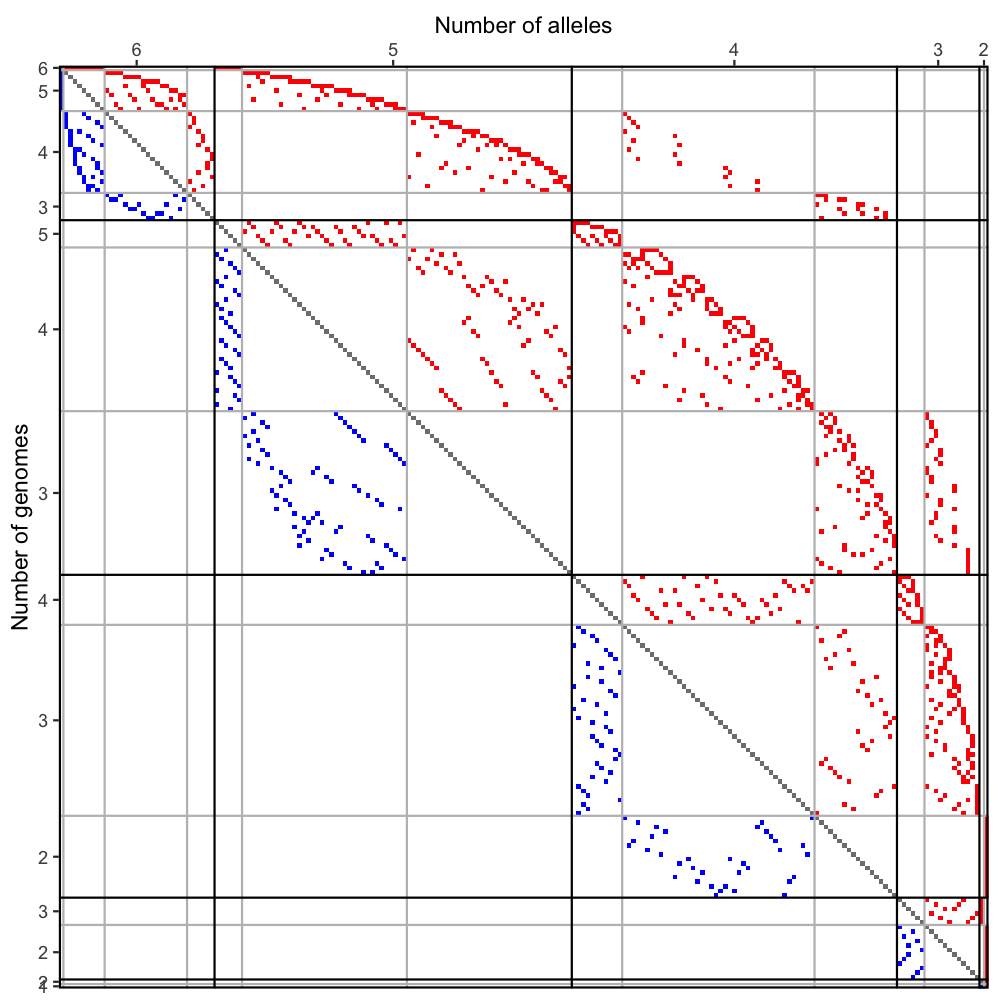

In [94]:
%%R -i tab_mat_3 -i cutpoints_3_1  -i cutpoints_3_2 -w 1000 -h 1000 -r 150

cutpoints_3_1 <- tibble(x = unlist(cutpoints_3_1))
cutpoints_3_2 <- tibble(x = unlist(cutpoints_3_2))
a <- sort(c(0, max(tab_mat_3$to)+1, cutpoints_3_1$x, cutpoints_3_2$x))
a <- a[-length(a)] + diff(a)/2 - 0.5
b <- sort(c(0, max(tab_mat_3$to)+1, cutpoints_3_2$x))
b <- b[-length(b)] + diff(b)/2 - 0.5

library(tidyverse)

as_tibble(tab_mat_3) %>% 
    ggplot() +
    geom_tile(aes(to, from, fill = value)) +
    geom_tile(aes(x, y, fill = fill), 
              data = tibble(x = 0:max(tab_mat_3$to), y = 0:max(tab_mat_3$to), fill = NA)) +
    geom_hline(aes(yintercept = x-0.5), data = cutpoints_3_1, color = 'grey') +
    geom_vline(aes(xintercept = x-0.5), data = cutpoints_3_1, color = 'grey') +
    geom_hline(aes(yintercept = x-0.5), data = cutpoints_3_2) +
    geom_vline(aes(xintercept = x-0.5), data = cutpoints_3_2) +
    scale_y_reverse(
        name = 'Number of genomes',
        expand = c(0, 0), 
        breaks = a,
        labels = c(6:3, 5:3, 4:2, 3:2, 2:1)
    ) +
    scale_x_continuous(
        name = 'Number of alleles',
        expand = c(0, 0),
        breaks = b,
        labels = 6:2,
        position = "top"
    ) +
    theme(legend.position = 'none',
          panel.border = element_rect(colour = "black", fill = NA, size = 1),
          axis.line=element_blank(),
          panel.background=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
    scale_fill_manual(values = c('red', 'blue'))

In [30]:
203*203

41209

In [95]:
dat_3 = iter_lst_to_ggplot(iter_lst_3)

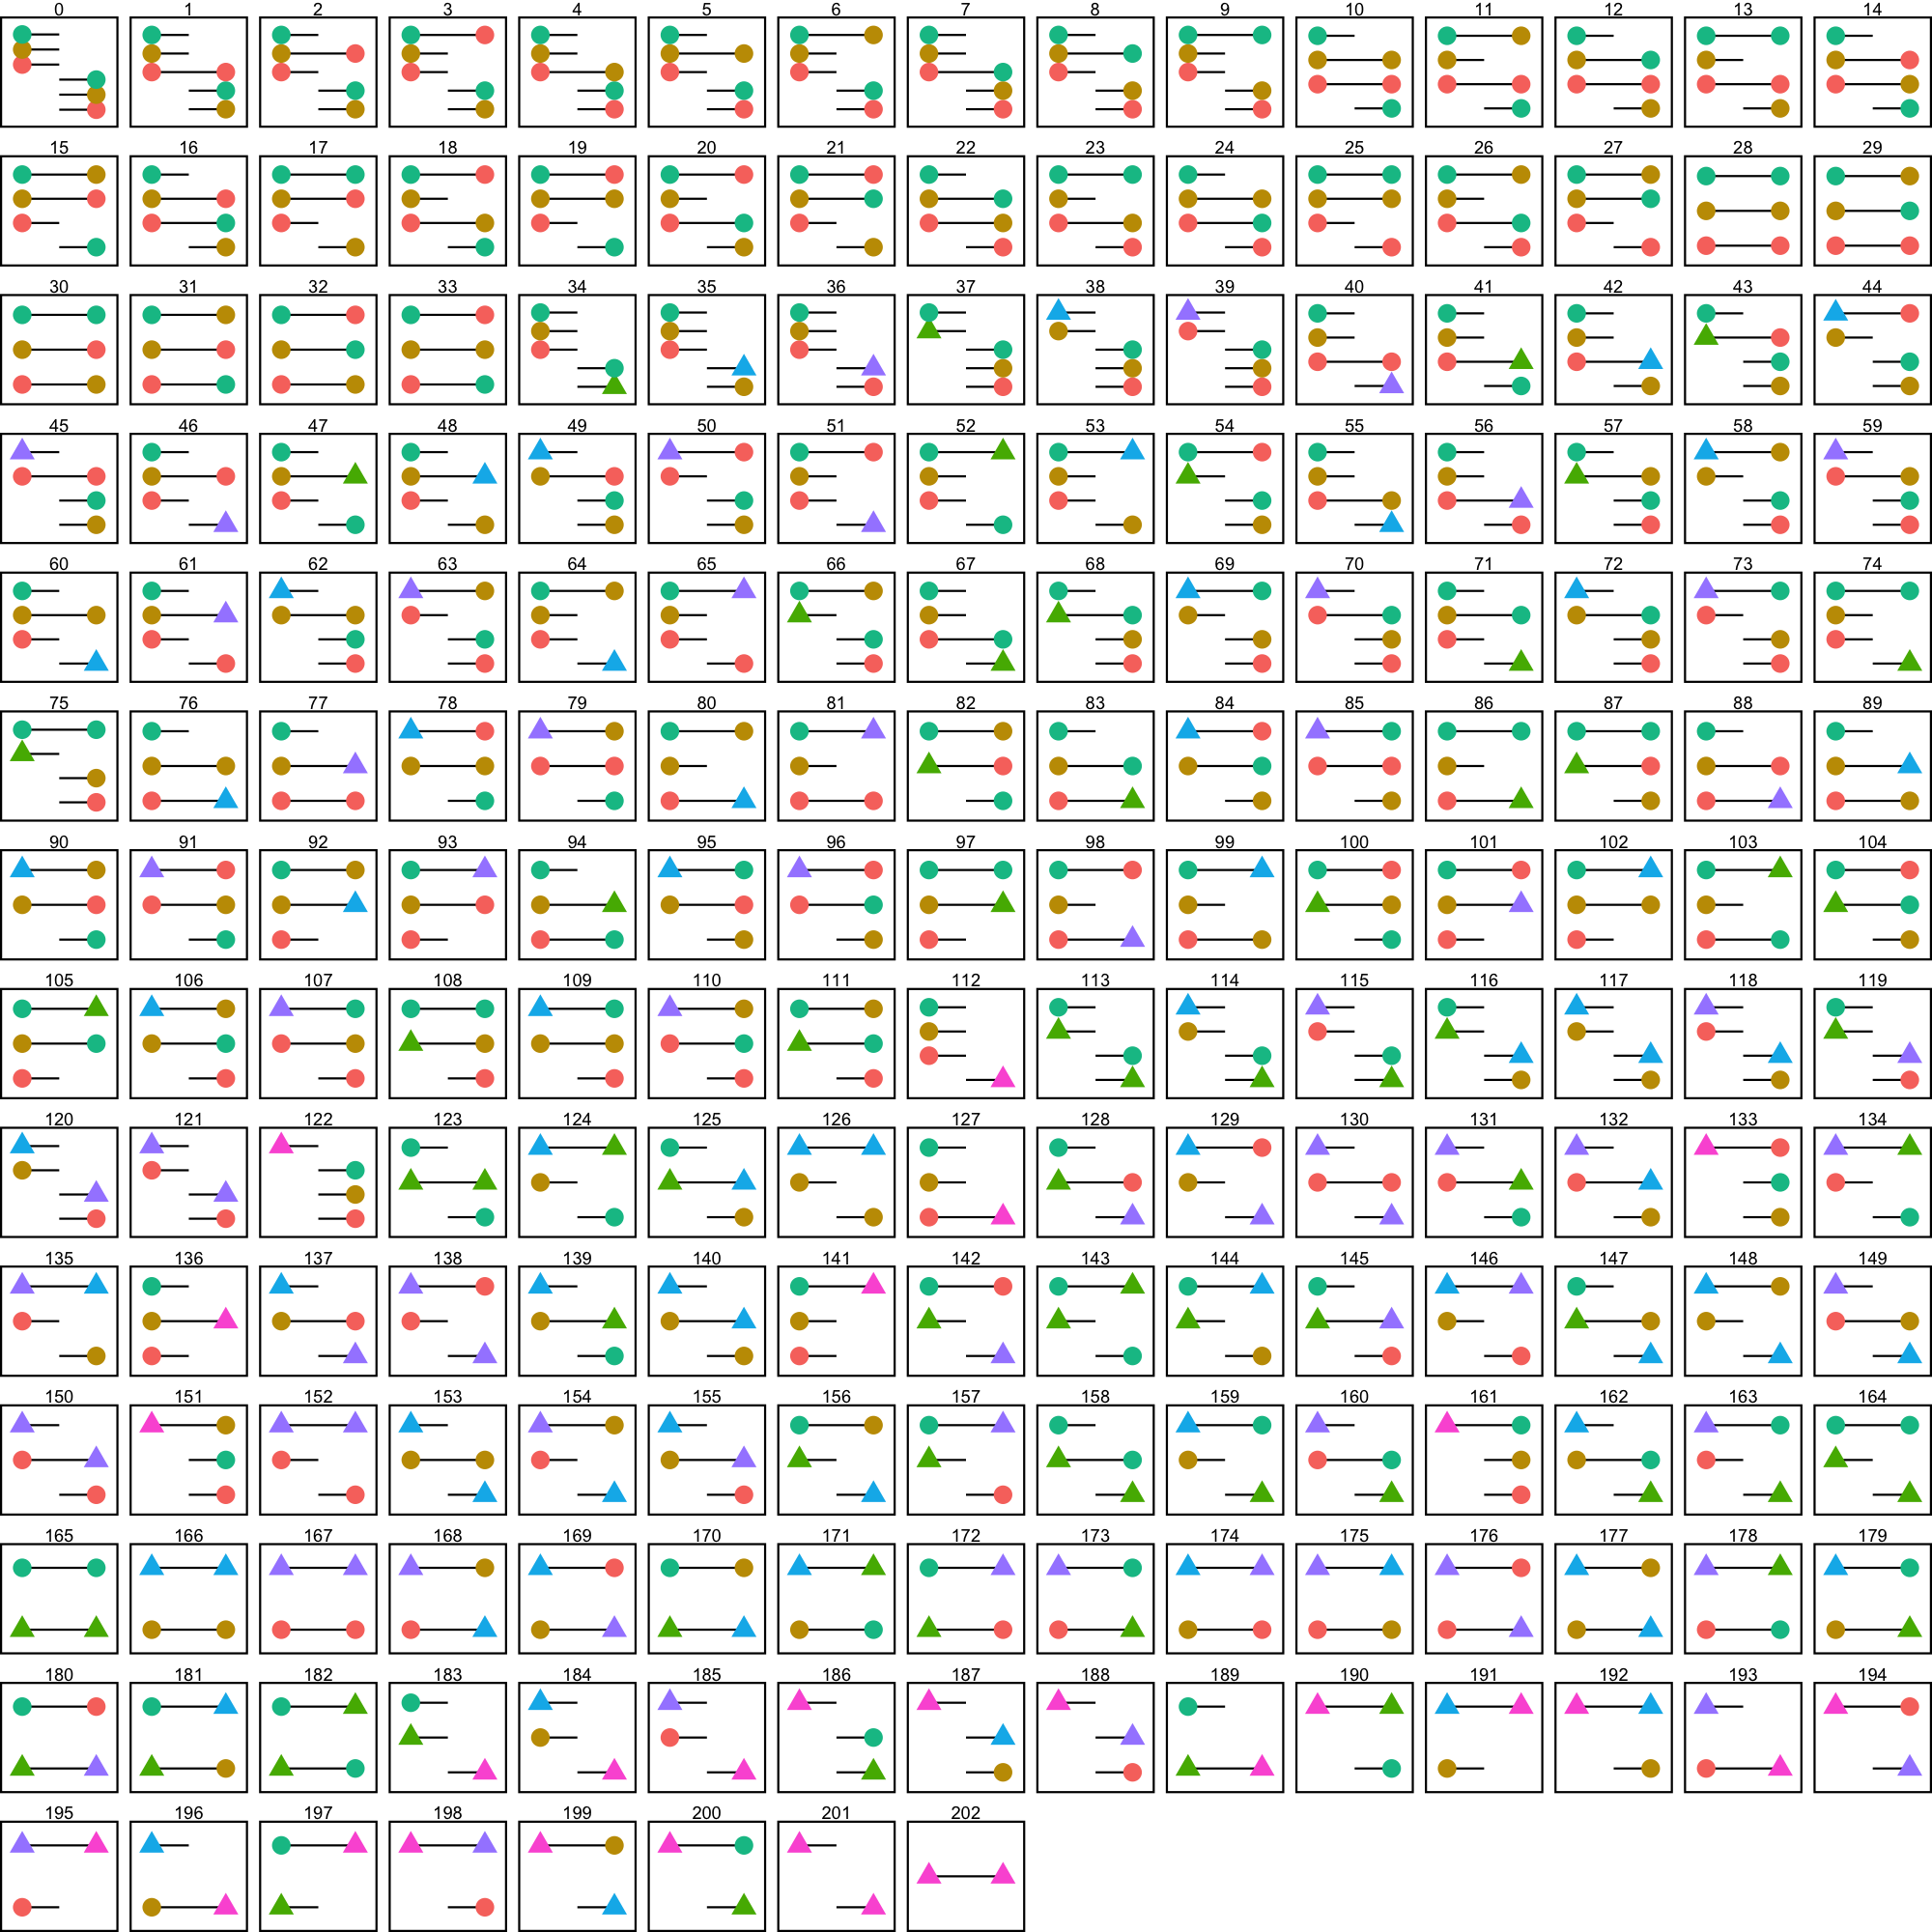

In [100]:
%%R -i dat_3 -w 2000 -h 2000 -r 150

as_tibble(dat_3) %>%
    mutate(
        dot_color_left = ifelse(dot_color_left == '-', NA, dot_color_left),
        dot_color_right = ifelse(dot_color_right == '-', NA, dot_color_right)
    ) %>%
    ggplot() +
    geom_segment(aes(x = seg_xmin, xend = seg_xmax,
                     y = seg_y, yend = seg_y)) +
    geom_point(aes(x = seg_xmin, y = seg_y, 
                   color = dot_color_left, fill = dot_color_left,
                  shape = dot_color_left %in% c('1', '2', '4')),
              size = 4) +
    geom_point(aes(x = seg_xmax, y = seg_y, color = dot_color_right,
              shape = dot_color_right %in% c('1', '2', '4')),
              size = 4) +
    theme_void() +
    facet_wrap(~id, scales = 'free') +
    scale_color_discrete(na.value = 'transparent') +
    scale_fill_discrete(na.value = 'transparent') +
    scale_shape_manual(values=c(17, 16)) +
    scale_x_continuous(expand = c(0.2, 0.2)) +
    scale_y_continuous(expand = c(0.2, 0.2)) +
    theme(legend.position = 'none',
          panel.border = element_rect(colour = "black", fill = NA, size = 1),
          axis.line=element_blank(),
          panel.background=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) 

## More populations

In [31]:
state_4 = [[(0, 1), (0, 2), (0, 4), (0, 8), (1, 0), (2, 0), (4, 0), (8, 0)]]
iter_lst_4 = get_states(state_4)
len(iter_lst_4)

4140

In [32]:
#state_4 = [[(0, 1), (0, 2), (0, 4), (0, 8), (1, 0), (2, 0), (4, 0), (8, 0)]]
#len(get_states_parallel(state_4))

In [33]:
cutpoints_4_1 = []
for i in range(1, len(iter_lst_4)):
    if len(iter_lst_4[i]) < len(iter_lst_4[i-1]):
        cutpoints_4_1.append(i)
cutpoints_4_1

[1,
 17,
 89,
 185,
 221,
 365,
 797,
 1135,
 1571,
 2387,
 2689,
 3201,
 3766,
 3998,
 4110,
 4139]

In [34]:
cutpoints_4_2 = []
for i in range(1, len(iter_lst_4)):
    if idx(iter_lst_4[i]) > idx(iter_lst_4[i-1]):
        cutpoints_4_2.append(i)
cutpoints_4_2

[209, 1085, 2603, 3705, 4096, 4138]

In [35]:
import numpy as np
trans_mat_4 = np.full((len(iter_lst_4), len(iter_lst_4)), '0')

for i in range(len(iter_lst_4)):
    new_lst = recombination(iter_lst_4[i])
    idx_lst = [iter_lst_4.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_4[i,j]='R'
    new_lst = coalescent(iter_lst_4[i])
    idx_lst = [iter_lst_4.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_4[i,j]='C'

In [36]:
df = pd.DataFrame(trans_mat_4)
new_df = (df.rename_axis(index = 'from')
            .reset_index()
            .melt('from', var_name='to')
            .reindex(columns = ['value','from','to']))
tab_mat_4 = new_df[new_df['value'] != '0']

In [37]:
len(tab_mat_4)

35446

In [38]:
4139*4139

17131321

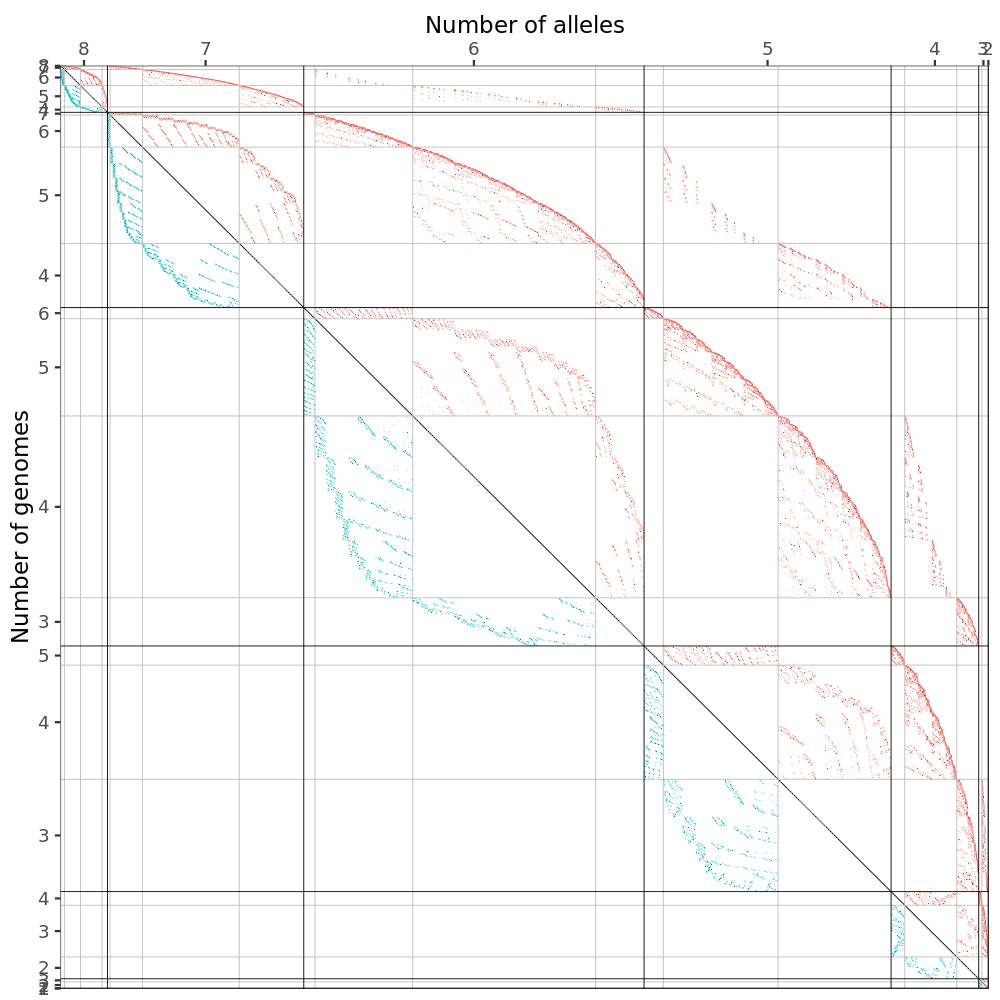

In [200]:
%%R -i tab_mat_4 -i cutpoints_4_1 -i cutpoints_4_2 -w 1000 -h 1000 -r 150

cutpoints_4_1 <- tibble(x = unlist(cutpoints_4_1))
cutpoints_4_2 <- tibble(x = unlist(cutpoints_4_2))
a <- sort(c(0, max(tab_mat_4$to)+1, cutpoints_4_1$x, cutpoints_4_2$x))
a <- a[-length(a)] + diff(a)/2 - 0.5
b <- sort(c(0, max(tab_mat_4$to)+1, cutpoints_4_2$x))
b <- b[-length(b)] + diff(b)/2 - 0.5

library(tidyverse)
    
        
tab_mat_4 %>% 
    as_tibble() %>% 
    ggplot() +
    geom_abline(aes(intercept = 0, slope = -1), size = 0.2) +
    geom_tile(aes(to, from, color = value)) +
    geom_tile(aes(x, y, fill = fill), 
              data = tibble(x = 0:max(tab_mat_4$to), y = 0:max(tab_mat_4$to), fill = NA)) +
    geom_hline(aes(yintercept = x-0.5), data = cutpoints_4_1, color = 'grey', size = 0.2) +
    geom_vline(aes(xintercept = x-0.5), data = cutpoints_4_1, color = 'grey', size = 0.2) +
    geom_hline(aes(yintercept = x-0.5), data = cutpoints_4_2, size = 0.2) +
    geom_vline(aes(xintercept = x-0.5), data = cutpoints_4_2, size = 0.2) +
    scale_y_reverse(
        name = 'Number of genomes',
        expand = c(0, 0), 
        breaks = a,
        labels = c(8:4, 7:4, 6:3, 5:3, 4:2, 3:2, 2:1)
    ) +
    scale_x_continuous(
        name = 'Number of alleles',
        expand = c(0, 0),
        breaks = b,
        labels = 8:2,
        position = "top"
    ) +
    theme(legend.position = 'none',
          panel.border = element_rect(colour = "black", fill = NA, size = 0.2),
          axis.line=element_blank(),
          panel.background=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
    scale_fill_manual(values = c('red', 'blue'))

## Surveying the state space for more populations

In [59]:
# state_5 = [[(0, 1), (0, 2), (0, 4), (0, 8), (0, 16), (1, 0), (2, 0), (4, 0), (8, 0), (16, 0)]]
# iter_lst_5 = get_states_parallel(state_5)
# 115975

The sequence of numbers corresponds to the Bell numbers for n = number of sites. A Bell number counts the number of different ways to partition a set that has exactly n elements. 